In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
print(tf.__version__)
for device in tf.config.list_physical_devices():
    print(device)

2.7.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

print("Train :", trainX.shape, trainy.shape)
print("Test :", testX.shape, testy.shape)

Train : (60000, 28, 28) (60000,)
Test : (10000, 28, 28) (10000,)


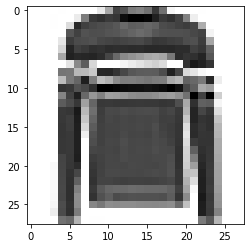

In [4]:
plt.imshow(trainX[5], cmap='gray_r')

In [5]:
def define_discriminator(in_shape=(28, 28, 1), n_classes=10):

    # FIRST INPUT
    In_label = keras.Input(shape=(1,))
    in_label = layers.Flatten()(
        layers.Embedding(input_dim=n_classes, output_dim=50)(In_label))
    nodes = in_shape[0] * in_shape[1]
    in_label = layers.Dense(nodes)(in_label)
    in_label = layers.Reshape((in_shape[0], in_shape[1], 1))(in_label)
    
    # SECOND INPUT
    in_image = keras.Input(shape=in_shape, name='images')
    
    merge = layers.Concatenate(axis=-1)([in_image, in_label])

    # conv
    features = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    features = layers.LeakyReLU(alpha=0.2)(features)
    
    features = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(features)
    features = layers.LeakyReLU(alpha=0.2)(features)

    features = layers.Flatten()(features)
    features = layers.Dropout(rate=0.4)(features)

    output = layers.Dense(1, activation='sigmoid')(features)

    model = keras.Model(inputs=[in_image, In_label], outputs=output, name='discriminator')
    # model.summary()

    opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    return model

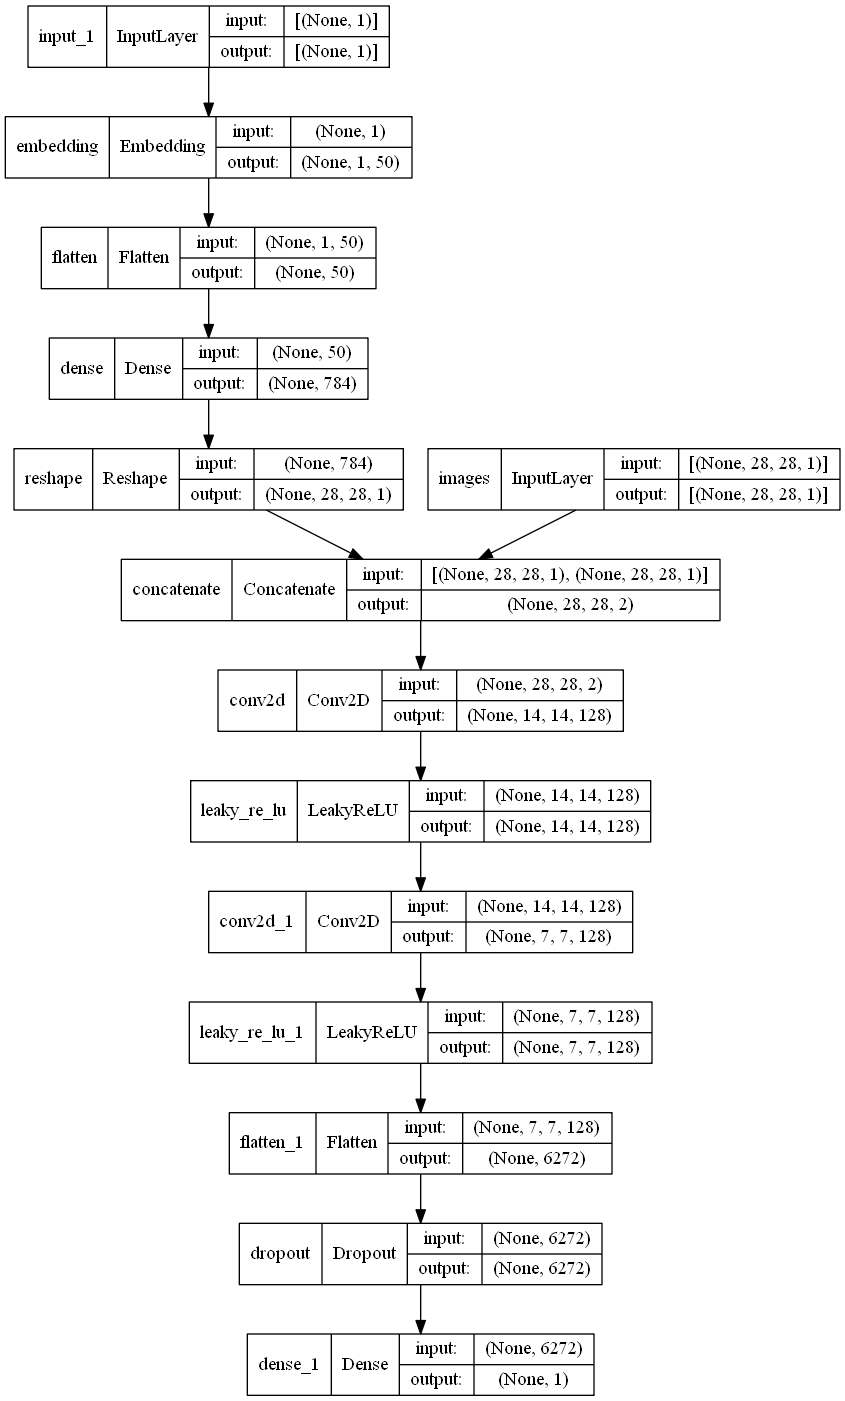

In [6]:
test_discriminator = define_discriminator()
plot_model(test_discriminator, show_shapes=True, to_file='discriminator.png')

In [7]:
def define_generator(latent_dim, n_classes=10):

    # label
    In_label = keras.Input(shape=(1,), name='label')
    in_label = layers.Flatten()(
        layers.Embedding(input_dim=n_classes, output_dim=50)(In_label)
    )
    nodes = 7 * 7
    in_label = layers.Dense(nodes)(in_label)
    in_label = layers.Reshape((7,7,1))(in_label)

    # sample from latent space
    In_latent = keras.Input(shape=(latent_dim,), name='prior')
    in_latent = layers.Dense(128*7*7)(In_latent)
    in_latent = layers.LeakyReLU(alpha=0.2)(in_latent)
    in_latent = layers.Reshape((7,7,128))(in_latent)

    merge = layers.Concatenate(axis=-1)([in_latent, in_label])

    # conv
    features = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    features = layers.LeakyReLU(alpha=0.2)(features)

    features = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(features)
    features = layers.LeakyReLU(alpha=0.2)(features)

    output = layers.Conv2D(1, (7,7), activation='tanh', padding='same')(features)

    model = keras.Model(inputs=[In_label, In_latent], outputs=output, name='generator')

    return model


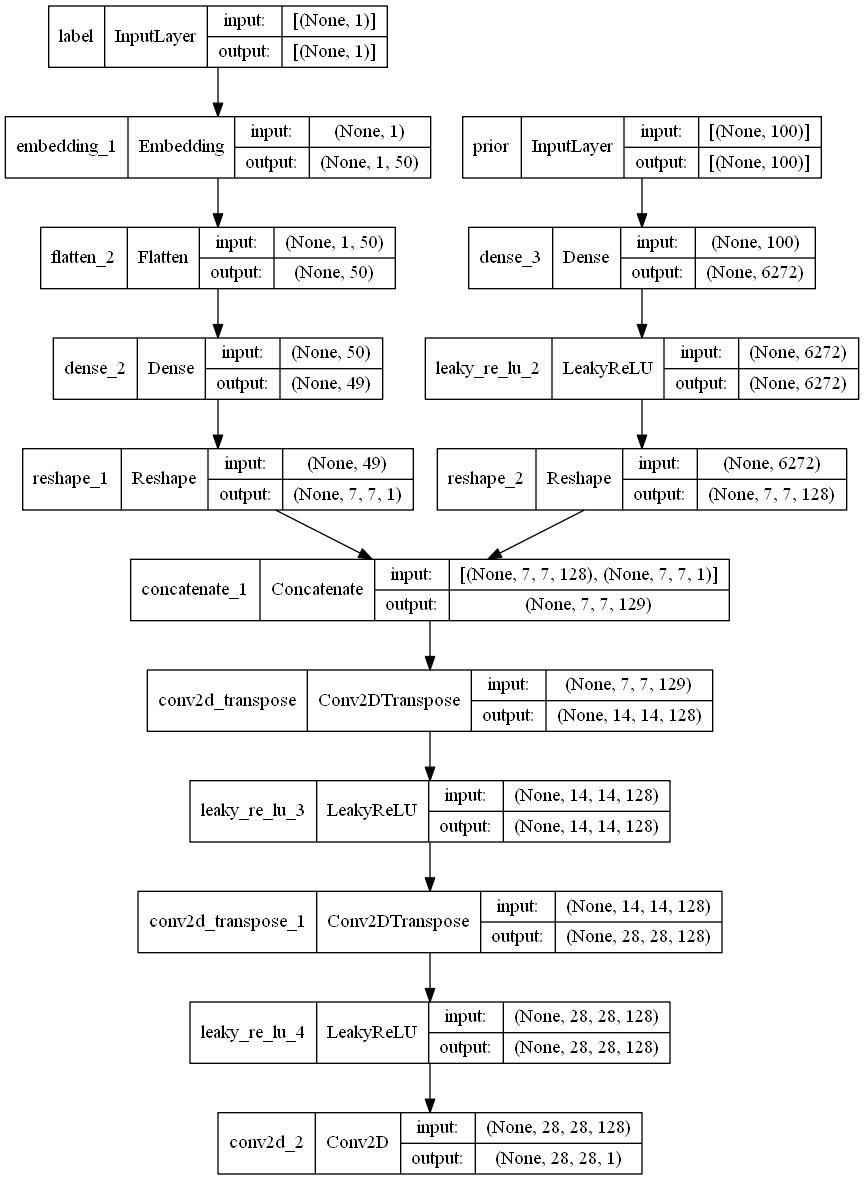

In [8]:
test_generator = define_generator(100)
plot_model(test_generator, 
    show_shapes=True, to_file='generator.png')

In [9]:
test_generator.input

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'label')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'prior')>]

In [10]:
def define_gan(G, D):

    D.trainable = False
    G_label, G_noise = G.input
    G_output = G.output

    output = D([G_output, G_label])
    model = keras.Model(inputs=[G_noise, G_label], outputs=output)
    
    opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, name='CGAN')
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt
    )

    return model

In [11]:
def load_real_samples():

    (trainX, trainy), (_, _) = fashion_mnist.load_data()
    X = np.expand_dims(trainX, axis=-1).astype('float32')
    X = (X -127.5) / 127.5

    return [X, trainy]

In [12]:
def generate_real_samples(dataset, n_sample):

    images, labels = dataset
    ix = np.random.randint(0, images.shape[0], n_sample)
    X, labels = images[ix], labels[ix]
    y = tf.ones(shape=(n_sample, 1))

    return [X, labels], y

In [13]:
def generate_latent_points(latent_dim, n_sample, n_classes=10):

    z_input  = np.random.rand(latent_dim * n_sample).reshape(n_sample, latent_dim)
    labels = np.random.randint(0, n_classes, size=n_sample)

    return [z_input, labels]

In [14]:
def generate_fake_samples(G, latent_dim, n_sample):

    z_input, labels_input = generate_latent_points(latent_dim, n_sample)
    images = G.predict([labels_input, z_input])
    y = tf.zeros((n_sample, 1))

    return [images, labels_input], y

In [15]:
def train(G, D, GAN, dataset, latent_dim, n_epoch=100, n_batch=128):

    batch_per_epoch = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    D_LOSS = []
    G_LOSS = []
    for epoch in range(n_epoch):
        for iteration in range(batch_per_epoch):

            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            D_loss1, _ = D.train_on_batch([X_real, labels_real], y_real)
            [X_fake, labels_fake], y_fake = generate_fake_samples(G, latent_dim, half_batch)
            D_loss2, _ = D.train_on_batch([X_fake, labels_fake], y_fake)

            [z_input, labels] = generate_latent_points(latent_dim, n_batch)
            y_gan = tf.ones((n_batch, 1))
            G_loss = GAN.train_on_batch([z_input, labels], y_gan)

            if iteration % 100 == 0:
                print('>%d, %d/%d, d_total=%.3f, g=%.3f' %
				    (epoch+1, iteration+1, batch_per_epoch, D_loss1+D_loss2, G_loss))
                generate_and_save_images(G, latent_dim)
                display.clear_output(wait=True)
            
                
                D_LOSS.append(D_loss1+D_loss2)
                G_LOSS.append(G_loss)
    
    G.save('C_Generator.h5')

    return D_LOSS, G_LOSS

In [16]:
def generate_and_save_images(G, latent_dim=100, n_sample=10):

  z_input  = np.random.rand(latent_dim * n_sample).reshape(n_sample, latent_dim)
  labels = np.arange(0, 10)
  
  predictions = G([labels, z_input], training=False)

  fig = plt.figure(figsize=(12, 12))

  for i in range(n_sample):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray_r')
      plt.axis('off')

  # plt.savefig('fakeimage_fashionmnist/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [17]:
latent_dim = 100
D = define_discriminator()
G = define_generator(latent_dim)
GAN = define_gan(G, D)

dataset = load_real_samples()
D_LOSS, G_LOSS = train(G, D, GAN, dataset, latent_dim)

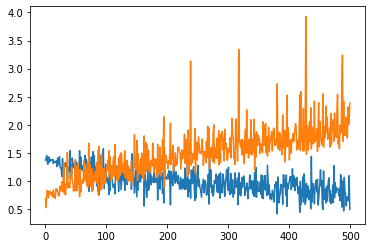

In [20]:
plt.plot(D_LOSS,)
plt.plot(G_LOSS,)
plt.show()

In [19]:
# from tensorflow.keras.models import load_model

# saved_generator = load_model('generator.h5')
# batch_size = 3
# noise = tf.random.normal(shape=(batch_size, 100))
# imgs = saved_generator(noise, training=False)
# # print(imgs.shape)
# # print(type(imgs))
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
# for i, img in enumerate(imgs):
#     axes[i].imshow(img.numpy().reshape((28,28)), cmap='gray_r')
#     axes[i].axis('off')